In [1]:
import json
import torch

from utils import init_sequential

import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import quad

import gc

PATH = Path('model')
ARCH = Path('arch')

FIGURES = Path('figures')
FIGURES_PRED = FIGURES / 'pred/'
FIGURES_EIGV = FIGURES / 'eigv/'
FIGURES_BASIS = FIGURES / 'basis/'
FIGURES_KERNEL = FIGURES / 'kernel/'
FIGURES_ERROR = FIGURES / 'error/'


FIGURES_PRED.mkdir(exist_ok=True, parents=True)
FIGURES_EIGV.mkdir(exist_ok=True, parents=True)
FIGURES_BASIS.mkdir(exist_ok=True, parents=True)
FIGURES_KERNEL.mkdir(exist_ok=True, parents=True)
FIGURES_ERROR.mkdir(exist_ok=True, parents=True)

SLIDE_FLAG = '_slide'

savefig = True
plt.rc('font', size=16)
plt.rc('lines', linewidth=3)

torch.set_grad_enabled(False)

torch.autograd.grad_mode.set_grad_enabled(mode=False)

In [2]:
name = 'S2_qs100_raw'
epoch = 2500

with open(ARCH / f'{name}.json', 'r') as f:
    params = json.load(f)

K = init_sequential(
    params['layers'],
    params['finish_with_activation'])

data = torch.load(PATH / params['name'] / f'{epoch}.model')

K.load_state_dict(data['K'][0])

<All keys matched successfully>

In [3]:
match params['quad-name']:
    case 'gaussian':
        int_p, int_w = quad.gaussian_quadrature(0, 1, params['quad-size'])
    case 'trapezoidal':
        int_p, int_w = quad.trapezoidal_rule(0, 1, params['quad-size'])
    case _:
        int_p, int_w = quad.trapezoidal_rule(0, 1, params['quad-size'])

In [4]:
print(K)

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): PAU(m=5, n=4, efficient=True)
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): PAU(m=5, n=4, efficient=True)
  (4): Linear(in_features=100, out_features=1, bias=True)
)


In [5]:
def loss(x, xpred):
    num = (x-xpred)**2 @ int_w
    den = x**2 @ int_w
    print(num, den)
    return (num/den).mean()

In [5]:
def model(xb, t):
    t1, t2 = torch.meshgrid(int_p, t, indexing='xy')
    t1t2 = torch.stack((t1, t2)).reshape(2, -1)
    Kt1t2 = K(t1t2.T).reshape((len(t), len(int_p)))
    return torch.einsum('bj,ij,j->bi', xb, Kt1t2, int_w)
    # n = len(t)
    # m = xb.shape[1]
    # int_p_aux, int_w_aux = quad.trapezoidal_rule(0, 1, m)
    
    # result = torch.zeros(xb.shape[0], n)
    # for j, t2 in enumerate(t):
    #     t1t2 = torch.stack((int_p_aux, t2.expand(m))).T
    #     Kt1t2 = K(t1t2).squeeze()

    #     for i, xi in enumerate(xb):
    #         result[i, j] += (xi * Kt1t2) @ int_w_aux
        
    # return result

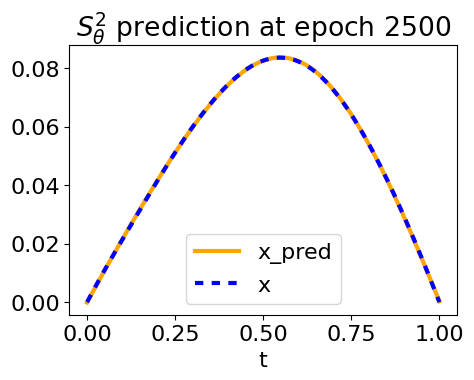

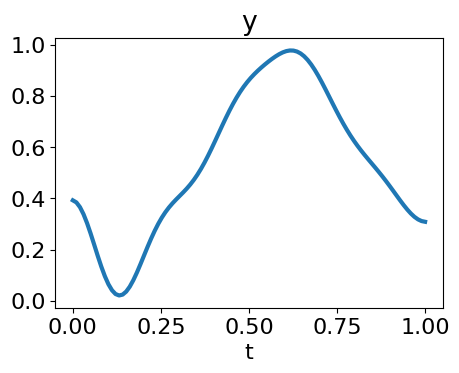

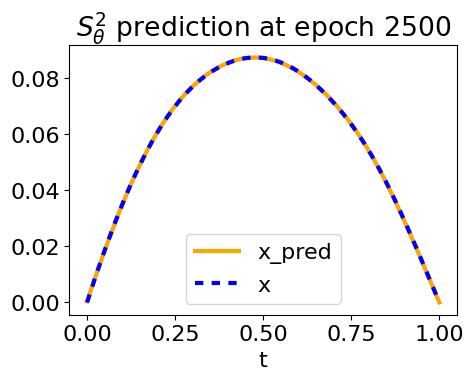

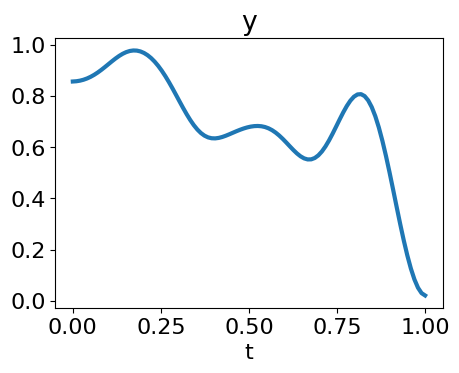

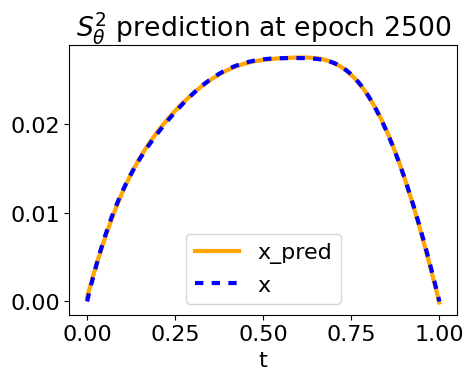

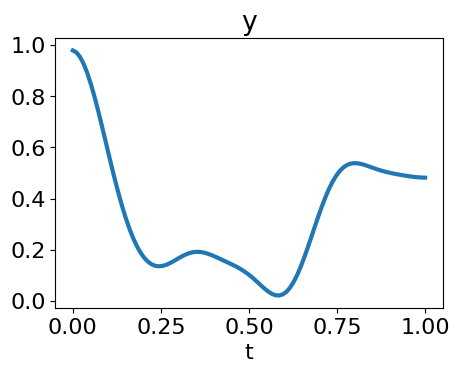

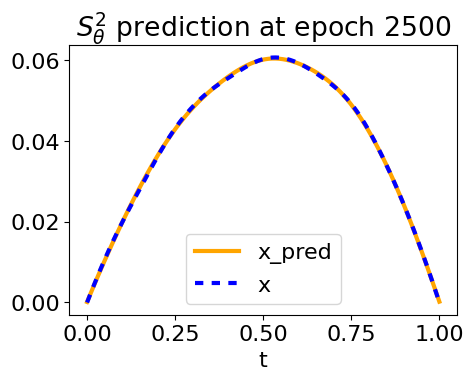

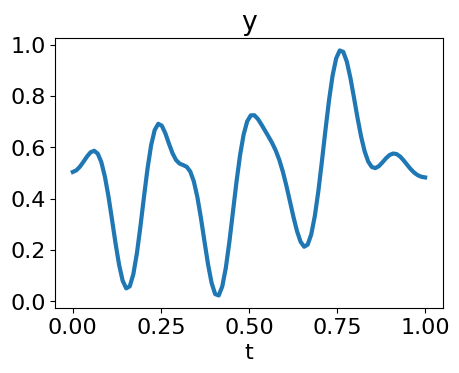

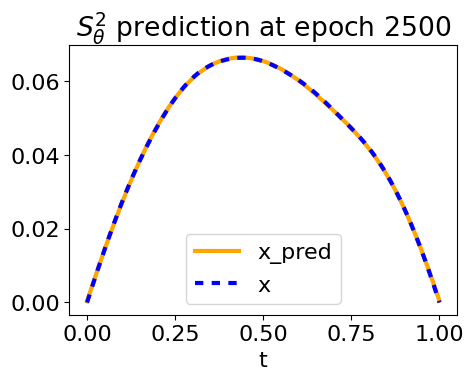

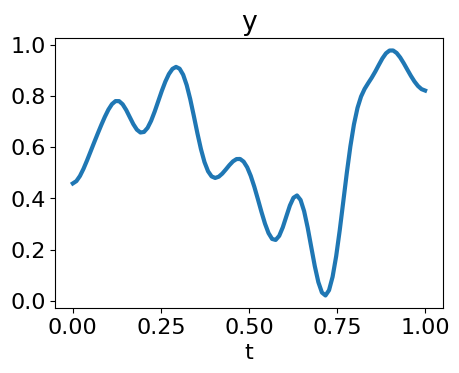

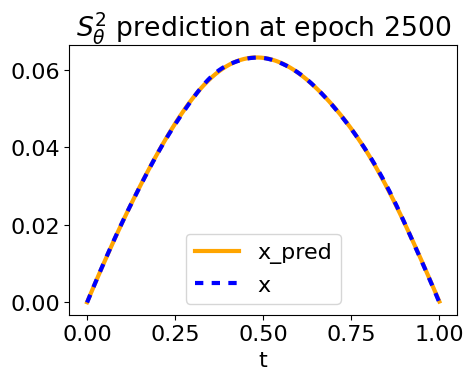

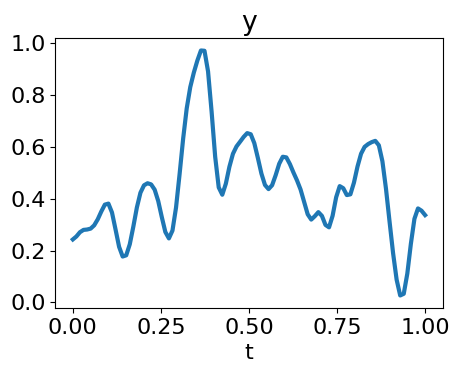

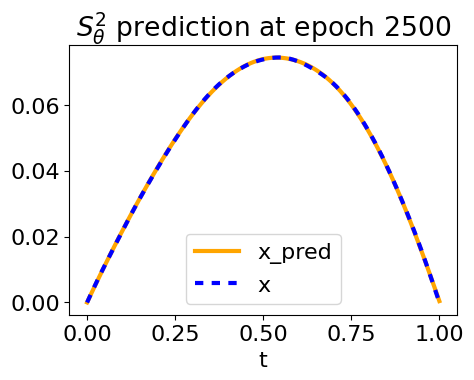

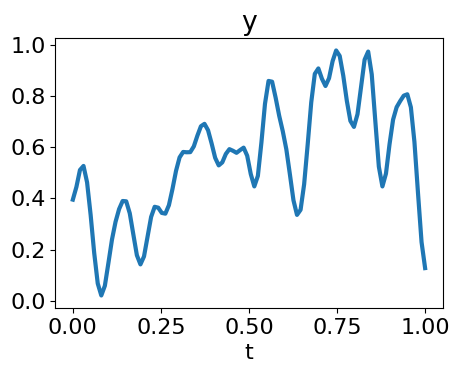

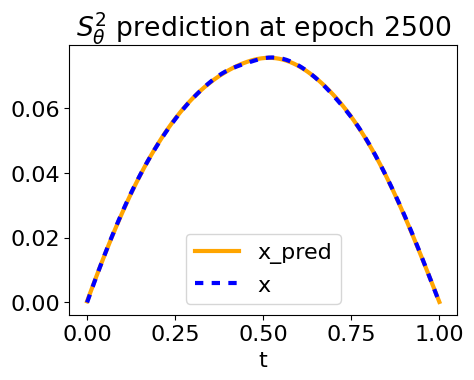

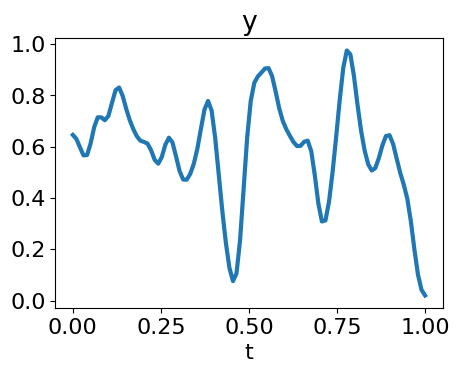

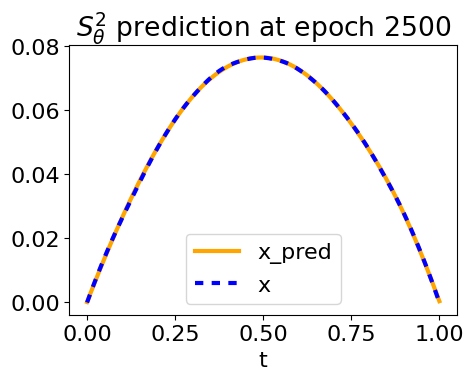

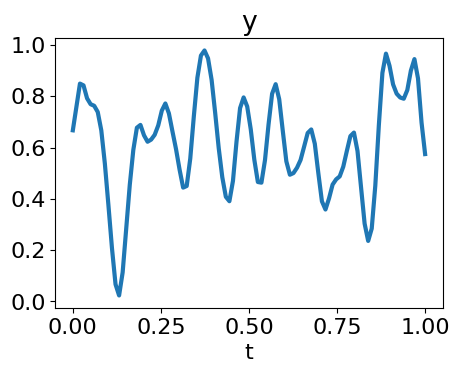

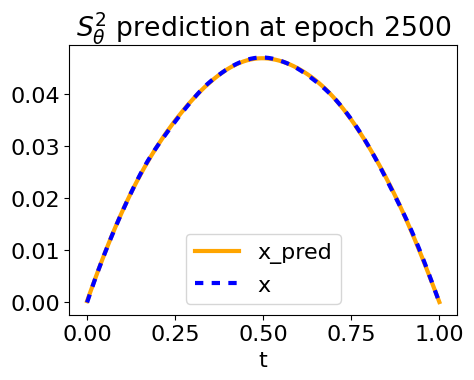

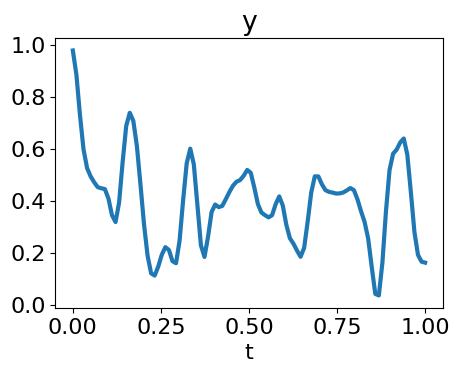

In [8]:
x_ds, y_ds = torch.load(PATH / params["name"] / 'valid.ds')
size = len(x_ds)
step = size // 10

N = 200
t = torch.linspace(0, 1, N)
for i, idx in enumerate(range(0, size, step)):
    Y = torch.load(f'dataset/ds20k/valid/{i}_Y.pt')
    X = torch.load(f'dataset/ds20k/valid/{i}_X.pt')

    ip = torch.linspace(0, 1, len(X)).numpy()
    
    x_pred = model(x_ds[idx].unsqueeze(dim=0), int_p).squeeze()
    
    plt.figure(figsize=(5, 3.5))
    plt.plot(int_p, x_pred, c='orange', label='x_pred')
    plt.plot(int_p, y_ds[idx], 'b--', dashes=[2], label='x')

    plt.xlabel('t')
    plt.legend()
    if savefig:
        plt.savefig(FIGURES_PRED / f'{params["name"]}_{epoch}_Fig{i}.png', bbox_inches = 'tight')
    plt.title(r'$S^2_{\theta}$' + f' prediction at epoch {epoch}')
    if savefig:
        plt.savefig(FIGURES_PRED / f'{params["name"]}_{epoch}_Fig{i}_with_title.png', bbox_inches = 'tight')
    plt.show()

    plt.figure(figsize=(5, 3.5))
    plt.plot(int_p, x_ds[idx], label='y')
    plt.xlabel('t')
    if savefig:
        plt.savefig(FIGURES_PRED / f'y_Fig{i}.png', bbox_inches = 'tight')
    plt.title('y')
    if savefig:
        plt.savefig(FIGURES_PRED / f'y_Fig{i}_with_title.png', bbox_inches = 'tight')
    plt.show()

    plt.close('all')
    gc.collect(2)

# Kernel

In [9]:
def compute_ticks(a):
    return [a.min(), a.mean(), a.max()]

In [10]:
N = 200
t = torch.linspace(0, 1, N)
tt = torch.stack(torch.meshgrid((t, t), indexing='xy')).reshape(2,-1)

_, int_w_aux = quad.trapezoidal_rule(0, 1, N)

Real_basis = []
for k in range(1, 9):
    den = torch.sin(torch.pi*k*int_p)**2 @ int_w
    Real_basis.append(torch.sin(torch.pi*k*t) / den)

Real_basis = torch.tensor(np.array(Real_basis)).float()
Real_eigv = [
    1/(torch.pi*k)**2
    for k in range(1, 9)
]

#  Gram-Schmidt
V = Real_basis
n = len(V)
Q = [None for _ in range(n)]
R = [[0.0 for __ in range(n)] for _ in range(n)]

_, int_w_aux = quad.trapezoidal_rule(0, 1, N)
for i in range(n):
    R[i][i] = torch.sqrt(V[i] * V[i] @ int_w_aux)
    Q[i] = V[i] / R[i][i]
    for j in range(i+1, n):
        R[i][j] = V[j] * Q[i] @ int_w_aux
        if abs(R[i][j]) >= 1e-1:
            V[j] = V[j] - (Q[i] * R[i][j])
#  End Gram-Schmidt

Real_basis = np.array(Q)

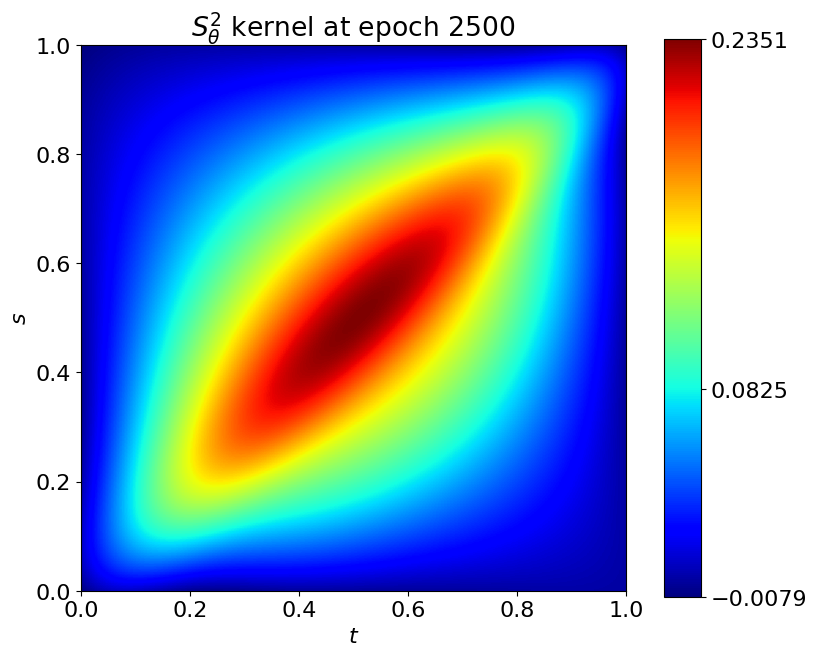

In [22]:
# savefig=True
k = K(tt.T).reshape(N, N)

plt.figure(figsize=(8, 8))
plt.imshow(k.flip(0), cmap='jet', extent=[0, 1, 0, 1])
plt.xlabel(r'$t$')
plt.ylabel(r'$s$')
if savefig:
    plt.savefig(FIGURES_KERNEL / f'{params["name"]}_epoch{epoch}.png', bbox_inches='tight')
plt.colorbar(location='right', aspect=15, fraction=0.06, pad=0.06, ticks=compute_ticks(k))
if savefig:
    plt.savefig(FIGURES_KERNEL / f'{params["name"]}_epoch{epoch}_with_cbar.png', bbox_inches='tight')
plt.title(r'$S^2_{\theta}$' + f' kernel at epoch {epoch}')
if savefig:
    plt.savefig(FIGURES_KERNEL / f'{params["name"]}_epoch{epoch}_with_cbar_with_title.png', bbox_inches='tight')
plt.show()

# Kernel2Basis

In [13]:
U, S, _ = torch.linalg.svd(k)

In [14]:
def compute_EIGV(BASIS):
    EIGV = []
    for i, b in enumerate(BASIS):
        benc = np.interp(np.linspace(0, 1, params['quad-size']), t, b)
        bint = torch.tensor(np.interp(int_p, t, b)).float()
        num = (bint * model(torch.tensor(benc).float().unsqueeze(dim=0), int_p)) @ int_w
        den = (bint * bint) @ int_w
        EIGV.append(num / den)
    
    return torch.tensor(EIGV)

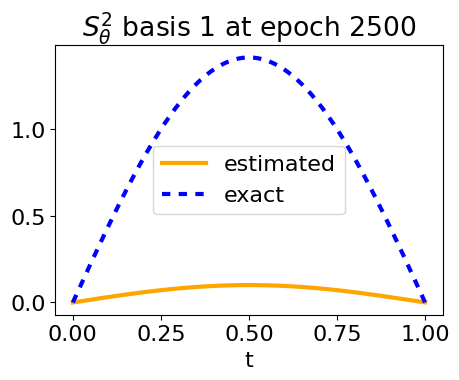

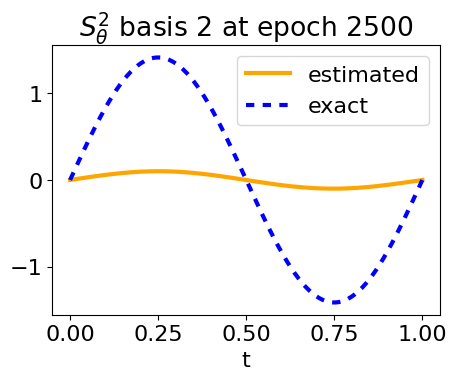

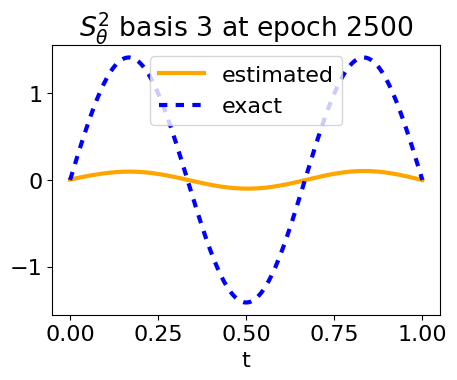

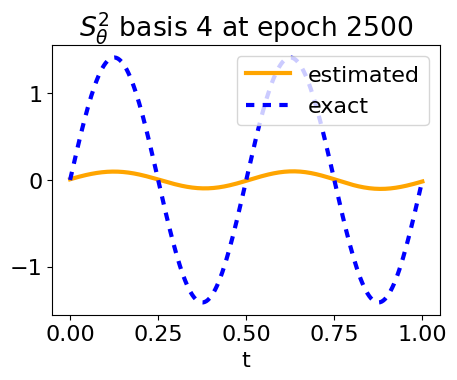

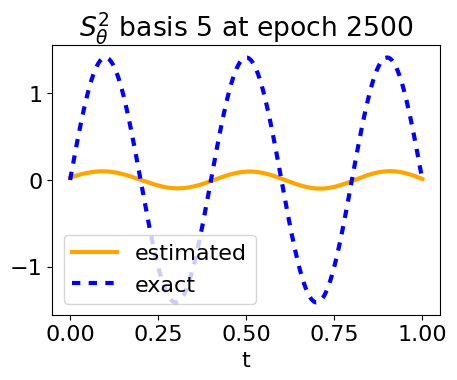

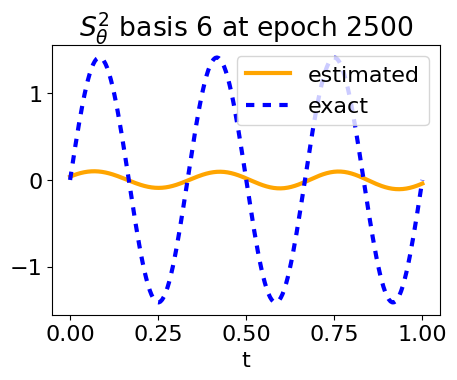

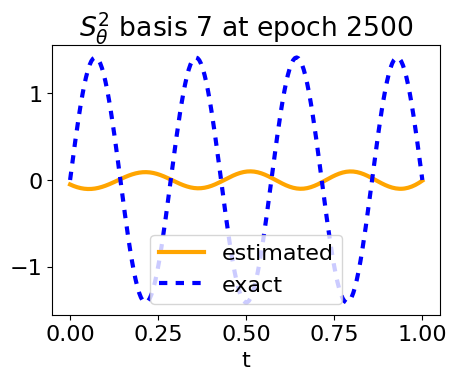

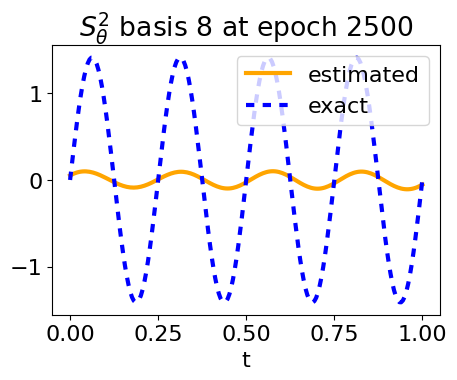

In [15]:
BASIS = U.T[:8]
EIGV = compute_EIGV(BASIS)

idx = torch.argsort(EIGV, descending=True)

EIGV = EIGV[idx]
BASIS = BASIS[idx]

for i, b in enumerate(BASIS):
    plt.figure(figsize=(5, 3.5))
    plt.plot(t, b, c='orange', label='estimated')
    plt.plot(t, Real_basis[i], 'b--', dashes=[2], label='exact')

    plt.xlabel('t')
    plt.legend()
    if savefig:
        plt.savefig(FIGURES_BASIS / f'{params["name"]}_epoch{epoch}_Fig{i}.png', bbox_inches='tight')
    plt.title(r'$S^2_{\theta}$' + f' basis {i+1} at epoch {epoch}')
    if savefig:
        plt.savefig(FIGURES_BASIS / f'{params["name"]}_epoch{epoch}_Fig{i}_with_title.png', bbox_inches='tight')
    plt.show()

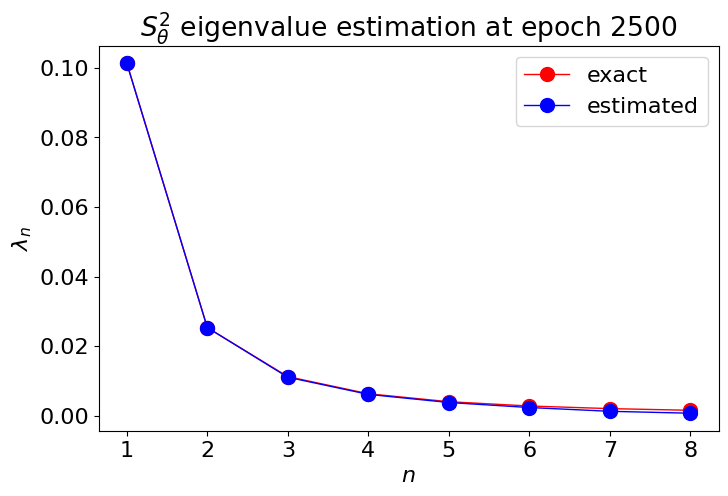

In [16]:
plt.figure(figsize=(8, 5))
plt.plot(list(range(1, 9)), 
         [1/(torch.pi*k)**2 for k in range(1, len(BASIS)+1)], 
         'or-', label='exact',
        markersize=10, linewidth=1)
plt.plot(list(range(1, 9)), EIGV, 'ob-',label='estimated',
        markersize=10, linewidth=1)
plt.legend()
plt.ylabel(r'$\lambda_n$')
plt.xlabel(r'$n$')
if savefig:
    plt.savefig(FIGURES_EIGV / f'{params["name"]}_epoch{epoch}.png', bbox_inches='tight')
plt.title(r'$S^2_{\theta}$' + f' eigenvalue estimation at epoch {epoch}')
if savefig:
    plt.savefig(FIGURES_EIGV / f'{params["name"]}_epoch{epoch}_with_title.png', bbox_inches='tight')
plt.show()

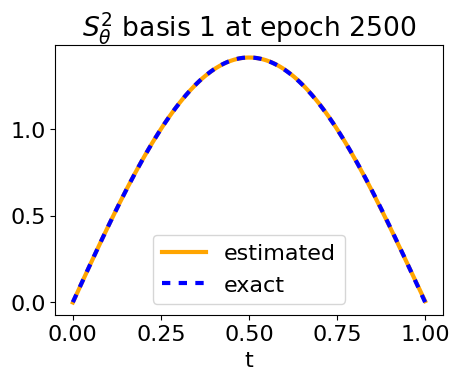

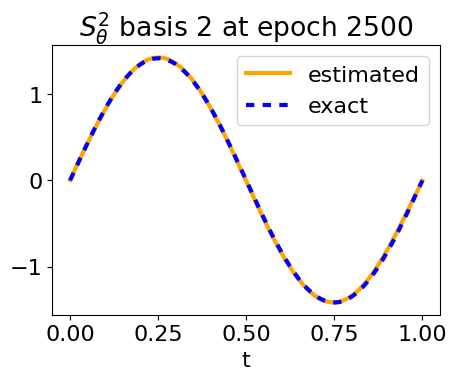

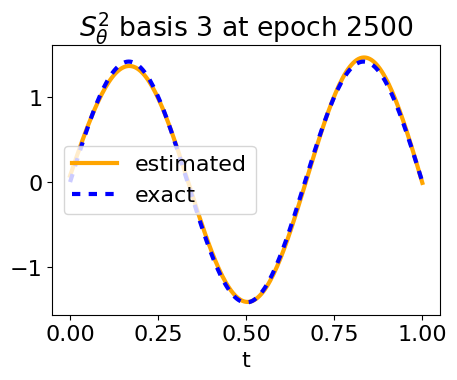

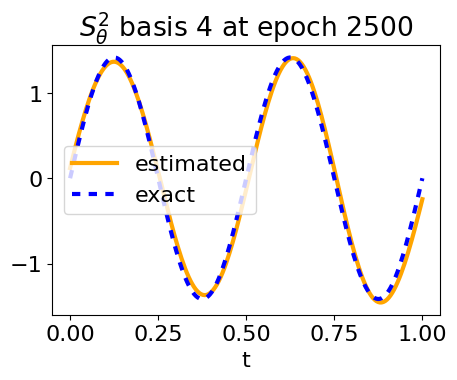

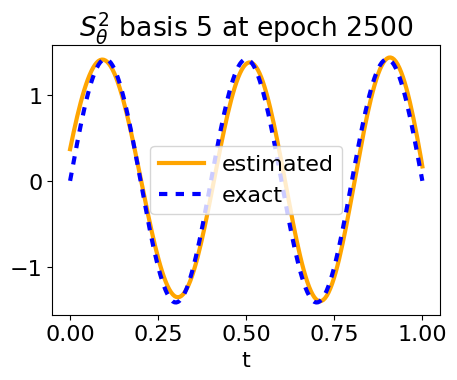

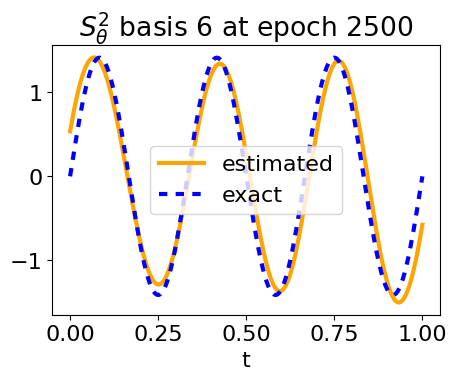

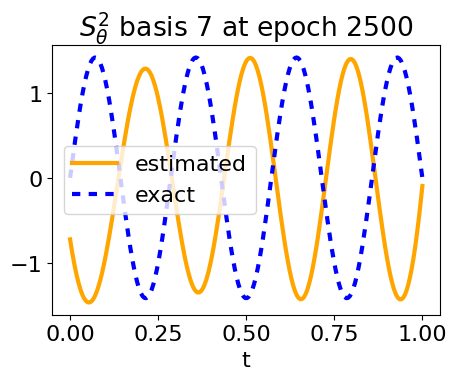

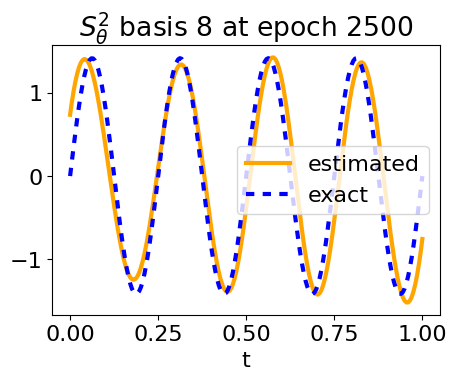

In [17]:
#  Gram-Schmidt
V = BASIS
n = len(V)
Q = [None for _ in range(n)]
R = [[0.0 for __ in range(n)] for _ in range(n)]

for i in range(n):
    R[i][i] = torch.sqrt(V[i] * V[i] @ int_w_aux)
    Q[i] = V[i] / R[i][i]
    for j in range(i+1, n):
        R[i][j] = V[j] * Q[i] @ int_w_aux
        if abs(R[i][j]) >= 1e-1:
            V[j] = V[j] - (Q[i] * R[i][j])
#  End Gram-Schmidt

O_BASIS = torch.stack(Q)
O_EIGV = compute_EIGV(O_BASIS)

idx = torch.argsort(O_EIGV, descending=True)

O_EIGV = O_EIGV[idx]
O_BASIS = O_BASIS[idx]

for i, b in enumerate(O_BASIS):
    plt.figure(figsize=(5, 3.5))
    plt.plot(t, b, c='orange', label='estimated')
    plt.plot(t, Real_basis[i], 'b--', dashes=[2], label='exact')

    plt.xlabel('t')
    plt.legend()
    if savefig:
        plt.savefig(FIGURES_BASIS / f'{params["name"]}_orth_epoch{epoch}_Fig{i}.png', bbox_inches='tight')
    plt.title(r'$S^2_{\theta}$' + f' basis {i+1} at epoch {epoch}')
    if savefig:
        plt.savefig(FIGURES_BASIS / f'{params["name"]}_orth_epoch{epoch}_Fig{i}_with_title.png', bbox_inches='tight')
    plt.show()

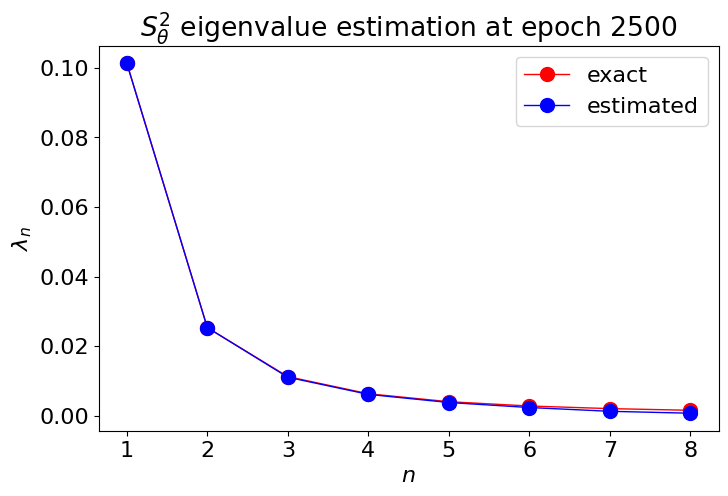

In [18]:
plt.figure(figsize=(8, 5))
plt.plot(list(range(1, 9)), [1/(torch.pi*k)**2 for k in range(1, len(O_BASIS)+1)],
         'or-', label='exact',
        markersize=10, linewidth=1)
plt.plot(list(range(1, 9)), O_EIGV, 'ob-', label='estimated',
        markersize=10, linewidth=1)
plt.legend()
plt.ylabel(r'$\lambda_n$')
plt.xlabel(r'$n$')
if savefig:
    plt.savefig(FIGURES_EIGV / f'{params["name"]}_orth_epoch{epoch}.png', bbox_inches='tight')
plt.title(r'$S^2_{\theta}$' + f' eigenvalue estimation at epoch {epoch}')
if savefig:
    plt.savefig(FIGURES_EIGV / f'{params["name"]}_orth_epoch{epoch}_with_title.png', bbox_inches='tight')
plt.show()

In [4]:
def read_error_log(logfile, rf, max_epoch=-1):
    error = []
    with open(logfile) as f:
        for line in f.readlines():
            epoch, err = line.split(',')

            if max_epoch > 0 and int(epoch) > max_epoch:
                break
            
            if int(epoch) % rf == 0:
                error.append(float(err))

    return error

In [5]:
rf = epoch // 5

valid_error = read_error_log(PATH / params['name'] / 'valid.error', rf, epoch)
train_error = read_error_log(PATH / params['name']  / 'train.error', rf, epoch)

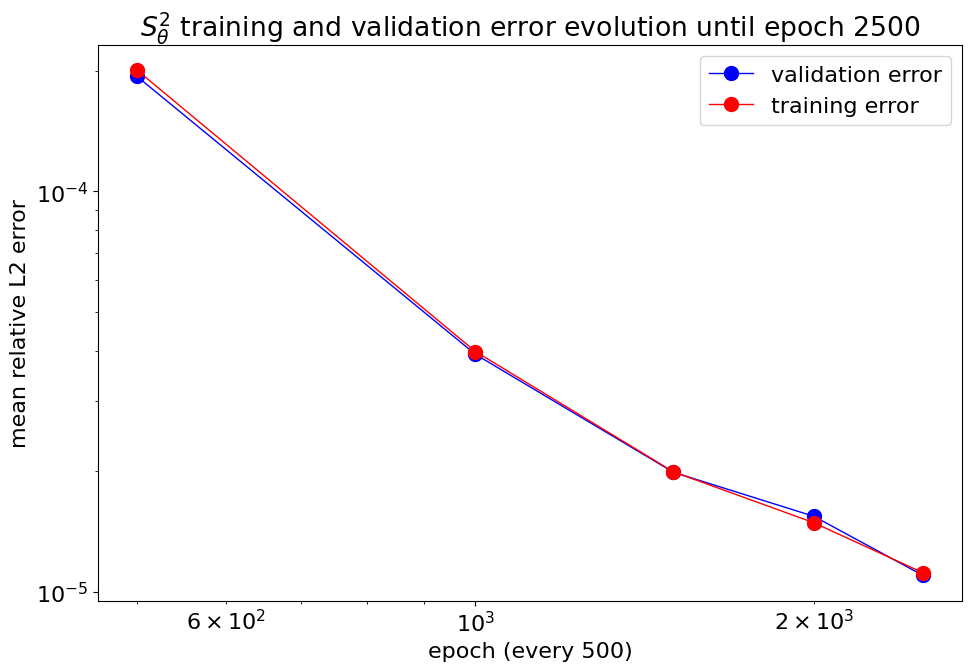

In [6]:
timeline = [k for k in range(rf, epoch+rf, rf)]

plt.figure(figsize=(10, 7))

plt.loglog(timeline, valid_error, 'ob-', label='validation error', markersize=10, linewidth=1)
plt.loglog(timeline, train_error, 'or-', label='training error', markersize=10, linewidth=1)
plt.xlabel(f'epoch (every {rf})')
plt.ylabel('mean relative L2 error')
plt.title(r'$S^2_{\theta}$' + f' training and validation error evolution until epoch {epoch}')
plt.tight_layout()
plt.legend()
if savefig:
    plt.savefig(FIGURES_ERROR / f'{params["name"]}_epoch{epoch}_with_title{SLIDE_FLAG}.png')

<Figure size 800x500 with 0 Axes>

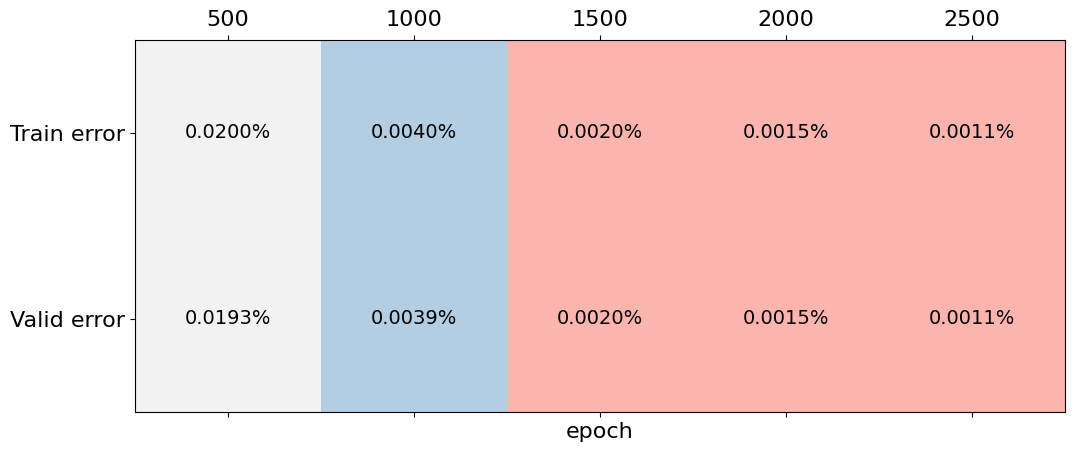

In [8]:
data = np.array(list(zip(train_error, valid_error))).T

plt.figure(figsize=(8, 5))
plt.tight_layout()
plt.matshow(100 * data, cmap='Pastel1')
plt.xlabel('epoch')
plt.xticks(np.array(range(len(timeline))), timeline)
plt.yticks(list(range(2)), ['Train error', 'Valid error'])
# plt.title(r'$S^2_{\theta}$')

for (i, j), z in np.ndenumerate(data):
    plt.text(j, i, '{:0.4f}%'.format(100 * z), ha='center', va='center', fontsize=14)

if savefig:
    plt.savefig(FIGURES_ERROR / f'{params["name"]}_epoch{epoch}_table_notitle{SLIDE_FLAG}.png', bbox_inches='tight')
plt.show()